# Technology Focus - NanoString CosMx

The data was downloaded from [here](https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/nsclc-ffpe-dataset/) ([download link](https://datasets.cellxgene.cziscience.com/c1870f1f-ca36-4d96-b03b-7dc0e96d83ee.h5ad)). We applied Proseg 2 and 3 on the dataset.

In [ ]:
%load_ext autoreload
%autoreload 2

import gzip
import shutil
from pathlib import Path

import anndata as ad
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata as sd
import spatialdata_io  # noqa
import spatialdata_plot  # noqa
from scipy.sparse import csr_matrix
from shapely.affinity import affine_transform
from spatialdata.transformations import (
    get_transformation,
)
from tqdm.auto import tqdm

import segtraq

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: Fut

## Data Reading

First, we need to get the data into `spatialdata` format. For proseg 3, this is relatively easy, since it already provides a `spatialdata` object as output. For the CosMx default segmentation and proseg 2, we need to write some custom code to ensure we have all the necessary data.

### CosMx default segmentation

In [2]:
%%time
sdata_cosmx = spatialdata_io.cosmx(
    "/g/huber/projects/CODEX/segtraq/data/lung/CosMx/Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/"
)

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


WARNING  Found images and labels for 32 FOVs, but only 30 FOVs in the counts file.                                 
         The following FOVs are missing: {'32', '31'}                                                              
         ... will use only fovs in Table.                                                                          
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
WARNING  FOV 31 not found in counts file. Skipping image CellComposite_F031.jpg.                                   
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to 

In [3]:
%%time


def apply_spatialdata_affine(gdf, T):
    """
    Convert a spatialdata.Affine (3×3) into shapely's affine format
    and apply it to all geometries in the GeoDataFrame.
    """
    M = T.matrix  # 3x3 numpy array

    # Convert to shapely format (a, b, d, e, xoff, yoff)
    a = M[0, 0]
    b = M[0, 1]
    d = M[1, 0]
    e = M[1, 1]
    xoff = M[0, 2]
    yoff = M[1, 2]

    return gdf.set_geometry(gdf.geometry.apply(lambda geom: affine_transform(geom, (a, b, d, e, xoff, yoff))))


def apply_spatialdata_affine_points(df, T):
    """Apply a spatialdata.Affine transform to a DataFrame
    with `x` and `y` point coordinates."""
    M = T.matrix

    a, b, xoff = M[0, 0], M[0, 1], M[0, 2]
    d, e, yoff = M[1, 0], M[1, 1], M[1, 2]

    x = df["x"].to_numpy()
    y = df["y"].to_numpy()

    df["x"] = a * x + b * y + xoff
    df["y"] = d * x + e * y + yoff

    return df


# Shapes
all_shapes = []
for labels_key, labels in tqdm(sdata_cosmx.labels.items()):
    fov = labels_key.split("_")[0]
    df = sd.to_polygons(labels)

    df["label"] = np.where(df["label"] != "0", fov + "_" + df["label"].astype(str), "0")

    # apply affine transform from SpatialData
    T = get_transformation(labels)
    df = apply_spatialdata_affine(df, T)

    all_shapes.append(df)

all_shapes = pd.concat(all_shapes)
all_shapes.index = all_shapes["label"]
sdata_cosmx.shapes = {"cell_boundaries": sd.models.ShapesModel.parse(all_shapes)}
# ensuring the index matches the cells

# Obs / Table
obs = sdata_cosmx.tables["table"].obs.copy()
obs["cell"] = np.where(obs["cell_ID"] != 0, obs["fov"].astype(str) + "_" + obs["cell_ID"].astype(str), "0")
sdata_cosmx.tables["table"].obs = obs

# Transcripts
all_transcripts = []

for transcripts_key, transcripts in tqdm(sdata_cosmx.points.items()):
    fov = transcripts_key.split("_")[0]
    df = transcripts.compute()

    df["cell"] = np.where(df["cell_ID"] != 0, fov + "_" + df["cell_ID"].astype(str), "0")

    # apply affine transform from SpatialData
    T = get_transformation(transcripts)
    df = apply_spatialdata_affine_points(df, T)

    all_transcripts.append(df)

transcript_df = pd.concat(all_transcripts).reset_index(drop=True)
# transcript_df.index = transcript_df['cell']
sdata_cosmx.points["transcripts"] = sd.models.PointsModel.parse(transcript_df)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 48.9 s, sys: 2.21 s, total: 51.1 s
Wall time: 51.3 s


In [4]:
st_cosmx = segtraq.SegTraQ(
    sdata_cosmx,
    images_key=None,
    points_cell_id_key="cell",
    points_z_key="z_raw",
    points_gene_key="target",
    tables_area_volume_key="Area",
    tables_x_key=None,
    tables_y_key=None,
    shapes_cell_id_key="label",
    points_background_id="0",
    tables_cell_id_key="cell",
    nucleus_shapes_key=None,
)

We can plot our dataset to get an idea of what the data looks like.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                        

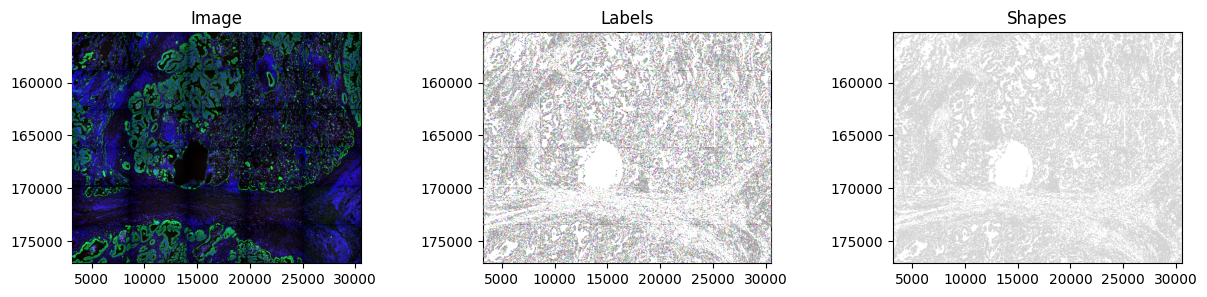

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sdata_cosmx.pl.render_images(element=None).pl.show(title="Image", coordinate_systems="global", ax=ax[0])
sdata_cosmx.pl.render_labels(element=None).pl.show(title="Labels", coordinate_systems="global", ax=ax[1])
sdata_cosmx.pl.render_shapes("cell_boundaries").pl.show(title="Shapes", coordinate_systems="global", ax=ax[2])

/home/meyerben/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/functools.py:934: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1697248].


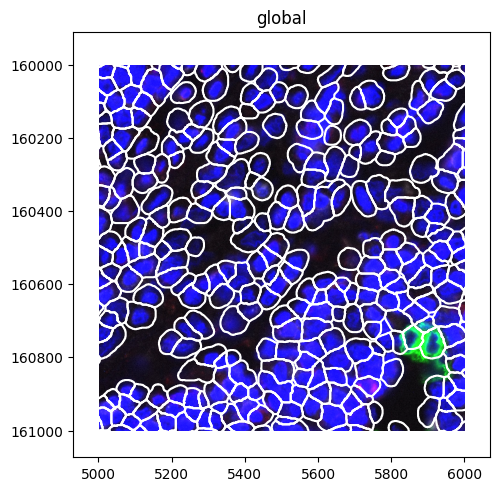

In [6]:
# zooming in on the segmentation
sdata_subset = sdata_cosmx.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[5000, 160000],
    max_coordinate=[6000, 161000],
    target_coordinate_system="global",
)

# unfortunately, spatialdata_plot does not allow changing the color or the outline, see https://github.com/scverse/spatialdata-plot/issues/462
sdata_subset.pl.render_images(element=None).pl.render_shapes(
    "cell_boundaries", outline_alpha=1, fill_alpha=0, outline_color="white"
).pl.show(coordinate_systems="global")

### Proseg 2

In [7]:
def read_proseg2(path):
    # -------------------------
    # Table (counts + metadata)
    # -------------------------
    counts_df = pd.read_csv(path / "expected-counts.csv.gz", compression="gzip")
    # print(counts_df)
    var = pd.DataFrame(index=counts_df.columns.astype(str))
    var.index.name = "gene_symbol"

    # Round to nearest int and convert to CSR
    X = np.rint(counts_df.values).astype(np.int32, copy=False)
    X = csr_matrix(X)

    obs = pd.read_csv(path / "cell-metadata.csv.gz", compression="gzip")
    obs["region"] = pd.Categorical(["cell_boundaries"] * len(obs))
    adata = ad.AnnData(X=X, obs=obs, var=var)
    table_sd = sd.models.TableModel.parse(adata, region_key="region", region="cell_boundaries", instance_key="cell")

    # -------------------------
    # Polygons -> per-layer shapes + raster labels (2D per z) + MIP
    # -------------------------
    def decompress_geojson(gz_path: Path) -> Path:
        if gz_path.suffix == ".gz":
            json_path = gz_path.with_suffix("")  # strip .gz

            if not json_path.exists():
                with gzip.open(gz_path, "rb") as f_in, open(json_path, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

            return json_path

        return gz_path

    # reading the polygons
    shapes_dict = {}

    polygons_layers_gdf = gpd.read_file(decompress_geojson(path / "cell-polygons-layers.geojson.gz"))

    # Polygon layers for multiple z stacks
    for z in sorted(polygons_layers_gdf["layer"].unique()):
        # select the current layer
        layer_gdf = polygons_layers_gdf[polygons_layers_gdf["layer"] == z]
        # filter out empty or missing geometries
        layer_gdf = layer_gdf[~layer_gdf.geometry.is_empty & layer_gdf.geometry.notna()]
        # putting everything into a spatialdata-compatible format
        layer_shapes = layer_gdf.set_index("cell")["geometry"].to_frame().copy()
        shapes_dict[f"cell_boundaries_z{int(z)}"] = sd.models.ShapesModel.parse(layer_shapes)

    polygons_gdf = gpd.read_file(decompress_geojson(path / "cell-polygons.geojson.gz"))
    gdf = polygons_gdf[~polygons_gdf.geometry.is_empty & polygons_gdf.geometry.notna()]
    shapes = gdf.set_index("cell")["geometry"].to_frame().copy()
    shapes_dict["cell_boundaries"] = sd.models.ShapesModel.parse(shapes)

    # -------------------------
    # Points (transcripts)
    # -------------------------
    tx = pd.read_csv(path / "transcript-metadata.csv.gz", compression="gzip")
    tx["gene"] = tx["gene"].astype("category")

    transcripts_sd = sd.models.PointsModel.parse(tx)

    # -------------------------
    # Assemble SpatialData
    # -------------------------
    sdata_proseg = sd.SpatialData(
        shapes=shapes_dict,
        points={"transcripts": transcripts_sd},
        tables={"table": table_sd},
    )

    return sdata_proseg


sdata_proseg2 = read_proseg2(Path("/g/huber/projects/CODEX/segtraq/data/lung/CosMx/proseg2"))

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
sdata_proseg2

SpatialData object
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 14) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (89309, 1) (2D shapes)
│     ├── 'cell_boundaries_z0': GeoDataFrame shape: (88973, 1) (2D shapes)
│     ├── 'cell_boundaries_z1': GeoDataFrame shape: (89290, 1) (2D shapes)
│     ├── 'cell_boundaries_z2': GeoDataFrame shape: (89308, 1) (2D shapes)
│     └── 'cell_boundaries_z3': GeoDataFrame shape: (89240, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (89309, 960)
with coordinate systems:
    ▸ 'global', with elements:
        transcripts (Points), cell_boundaries (Shapes), cell_boundaries_z0 (Shapes), cell_boundaries_z1 (Shapes), cell_boundaries_z2 (Shapes), cell_boundaries_z3 (Shapes)

In [9]:
st_p2 = segtraq.SegTraQ(
    sdata_proseg2,
    images_key=None,
    points_cell_id_key="assignment",
    points_gene_key="gene",
    tables_area_volume_key="volume",
    tables_x_key="centroid_x",
    tables_y_key="centroid_y",
    shapes_cell_id_key=None,
    points_background_id=4294967295,
    tables_cell_id_key="cell",
    nucleus_shapes_key=None,
)

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/SegTraQ.py:128: UserWarning: The shapes and tables indices do not match. This will lead to errors when using spatialdata_plot. IDs in shapes index: [0, 1, 2, 3, 4]..., IDs in tables index: ['61764', '25485', '65300', '70827', '53895']...
  validate_spatialdata(


### Proseg 3

In [10]:
# proseg already outputs spatialdata
sdata_proseg3 = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/lung/CosMx/proseg3/cosmx_proseg3.zarr/")

In [11]:
sdata_proseg3

SpatialData object, with associated Zarr store: /g/huber/projects/CODEX/segtraq/data/lung/CosMx/proseg3/cosmx_proseg3.zarr
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     └── 'cell_boundaries': GeoDataFrame shape: (91700, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (91700, 960)
with coordinate systems:
    ▸ 'global', with elements:
        transcripts (Points), cell_boundaries (Shapes)

In [12]:
st_p3 = segtraq.SegTraQ(
    sdata_proseg3,
    images_key=None,
    points_cell_id_key="assignment",
    points_gene_key="gene",
    tables_area_volume_key="volume",
    tables_x_key="centroid_x",
    tables_y_key="centroid_y",
    shapes_cell_id_key="cell",
    points_background_id=None,
    tables_cell_id_key="cell",
    nucleus_shapes_key=None,
)

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/SegTraQ.py:128: UserWarning: The shapes and tables indices do not match. This will lead to errors when using spatialdata_plot. IDs in shapes index: [0, 1, 2, 3, 4]..., IDs in tables index: ['61764', '25485', '65300', '70827', '53895']...
  validate_spatialdata(


In [13]:
# putting all objects into a dictionary
st_dict = {"cosmx": st_cosmx, "proseg2": st_p2, "proseg3": st_p3}

## Baseline Metrics

Let's start our analysis by investigating some basic properties of the different segmentations. This includes how many cells were detected, how many transcripts were assigned, and what the cell morphologies look like.

In [14]:
for method, st in st_dict.items():
    num_cells = st.bl.num_cells()
    p_unassigned = st.bl.perc_unassigned_transcripts()
    print(f"{method}: #cells: {num_cells}, % unassigned transcripts: {p_unassigned}")

cosmx: #cells: 100292, % unassigned transcripts: 18.41650636466764
proseg2: #cells: 89309, % unassigned transcripts: 1.1590487084044185
proseg3: #cells: 91700, % unassigned transcripts: 7.2637264395285746


We can see that Proseg generally segments less cells than CosMx, but also leaves less transcripts unassigned.

In [15]:
for _method, st in st_dict.items():
    st.bl.morphological_features(n_jobs=8)

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/bl/baseline.py:450: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = geom.area.values
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/bl/baseline.py:466: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeters = geom.length.values
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/bl/baseline.py:495: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  convex_areas = convex_hull.area.values
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/S

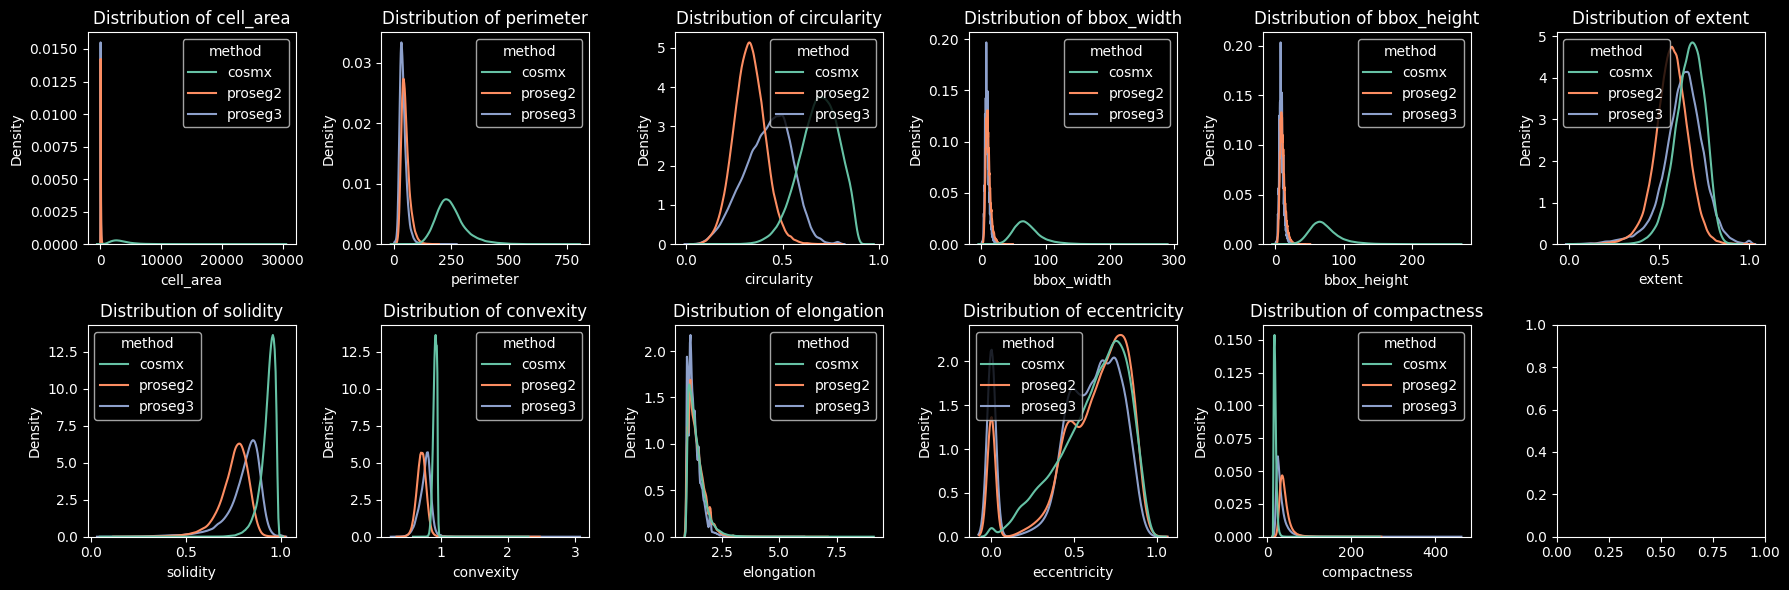

In [16]:
features = [
    "cell_area",
    "perimeter",
    "circularity",
    "bbox_width",
    "bbox_height",
    "extent",
    "solidity",
    "convexity",
    "elongation",
    "eccentricity",
    "compactness",
]

# Collect features into one dataframe
all_feats = []
for method, st in st_dict.items():
    feat = st.sdata["table"].obs[features]
    tmp = feat.copy()
    tmp["method"] = method
    all_feats.append(tmp)

df = pd.concat(all_feats, ignore_index=True)
df["method"] = df["method"].astype(str)

feature_cols = [c for c in df.columns if c != "method"]

# Apply dark background globally
plt.style.use("dark_background")

fig, ax = plt.subplots(2, 6, figsize=(6 * 3, 2 * 3), facecolor="black")
ax = ax.flatten()

for i, feat_name in enumerate(feature_cols):
    ax[i].set_facecolor("black")
    sns.kdeplot(data=df, x=feat_name, hue="method", palette="Set2", common_norm=False, fill=False, ax=ax[i])
    # White text for readability
    ax[i].set_title(f"Distribution of {feat_name}")
    ax[i].set_xlabel(feat_name)
    ax[i].set_ylabel("Density")
fig.tight_layout()
plt.show()

There are some striking differences between the segmentation methods. For example, the CosMx default segmentation seems to produce some very large cells, which do not occur with proseg.

## Clustering Stability

Next, we can have a look at the clustering stability.

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


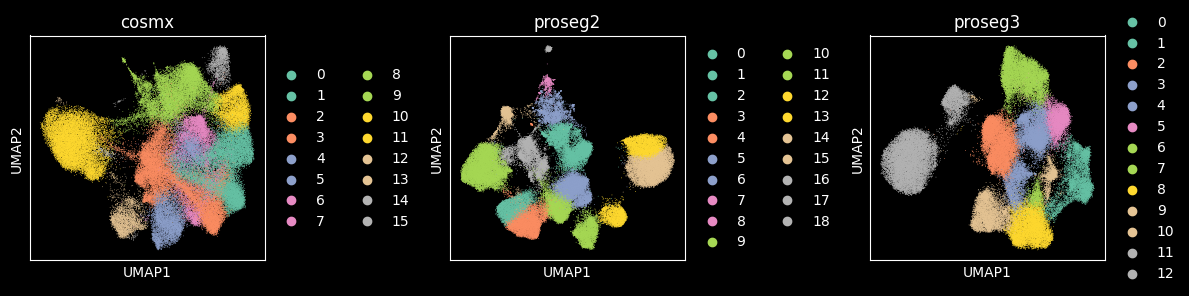

CPU times: user 4min 7s, sys: 420 ms, total: 4min 7s
Wall time: 3min 53s


In [17]:
%%time

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs = axs.flatten()

for i, (method, st) in enumerate(st_dict.items()):
    adata = st.sdata.tables["table"]
    adata.layers["raw"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

    sc.pl.umap(
        adata,
        color="leiden",
        palette="Set2",
        ax=axs[i],
        show=False,
        title=method,
    )

plt.tight_layout()
plt.show()

In [18]:
%%time
mcds = {}
silhouette_scores = {}
purities = {}
aris = {}

for method, st in tqdm(st_dict.items()):
    mcds[method] = st.cs.compute_mean_cosine_distance()
    silhouette_scores[method] = st.cs.compute_silhouette_score()
    purities[method] = st.cs.compute_purity()
    aris[method] = st.cs.compute_ari()

results_df = pd.DataFrame(
    {
        "Method": list(mcds.keys()),
        "MCD": list(mcds.values()),
        "Silhouette Score": list(silhouette_scores.values()),
        "Purity": list(purities.values()),
        "ARI": list(aris.values()),
    }
)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 20min 1s, sys: 1.75 s, total: 20min 3s
Wall time: 14min 4s


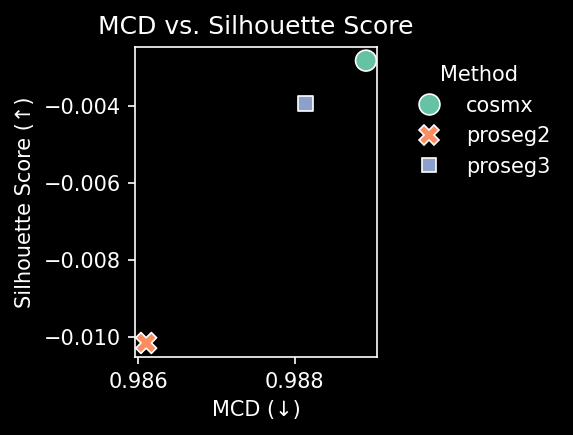

In [19]:
fig, ax = plt.subplots(figsize=(4, 3), facecolor="black", dpi=150)
ax.set_facecolor("black")

sns.scatterplot(
    data=results_df,
    x="MCD",
    y="Silhouette Score",
    hue="Method",
    style="Method",
    s=100,
    palette="Set2",
    ax=ax,
)

ax.set_xlabel("MCD (↓)", color="white")
ax.set_ylabel("Silhouette Score (↑)", color="white")
ax.set_title("MCD vs. Silhouette Score", color="white")
ax.tick_params(colors="white")

# Legend styling
legend = ax.legend(title="Method", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.setp(legend.get_texts(), color="white")
plt.setp(legend.get_title(), color="white")

fig.tight_layout()
plt.show()

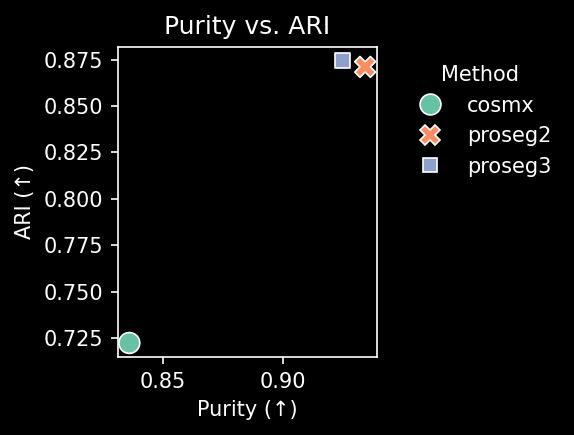

In [20]:
# Dark style
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(4, 3), facecolor="black", dpi=150)
ax.set_facecolor("black")

sns.scatterplot(
    data=results_df,
    x="Purity",
    y="ARI",
    hue="Method",
    style="Method",
    s=100,
    palette="Set2",  # consistent palette
    ax=ax,
)

ax.set_xlabel("Purity (↑)", color="white")
ax.set_ylabel("ARI (↑)", color="white")
ax.set_title("Purity vs. ARI", color="white")
ax.tick_params(colors="white")

# Legend styling
legend = ax.legend(title="Method", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.setp(legend.get_texts(), color="white")
plt.setp(legend.get_title(), color="white")

fig.tight_layout()
plt.show()

## Region Correlation
Most of the region correlation require both a whole-cell and a nucleus mask. CosMx does not provide a nuclear mask by default, so if you wish to compute those metrics, you have to run cellpose yourself on the nuclear stain. You can make use of `segtraq.add_nuc_shapes_via_cellpose()` for this. Here, we only show the methods that can be run without a nuclear segmentation.

In [21]:
for _method, st in tqdm(st_dict.items()):
    st.rc.compute_center_border_ncv_correlation()

  0%|          | 0/3 [00:00<?, ?it/s]

/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/rc/utils.py:170: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = cells_gdf.geometry.area
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/rc/utils.py:472: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = cells_gdf.geometry.centroid
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/rc/utils.py:475: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = cells_gdf.geometry.area
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/

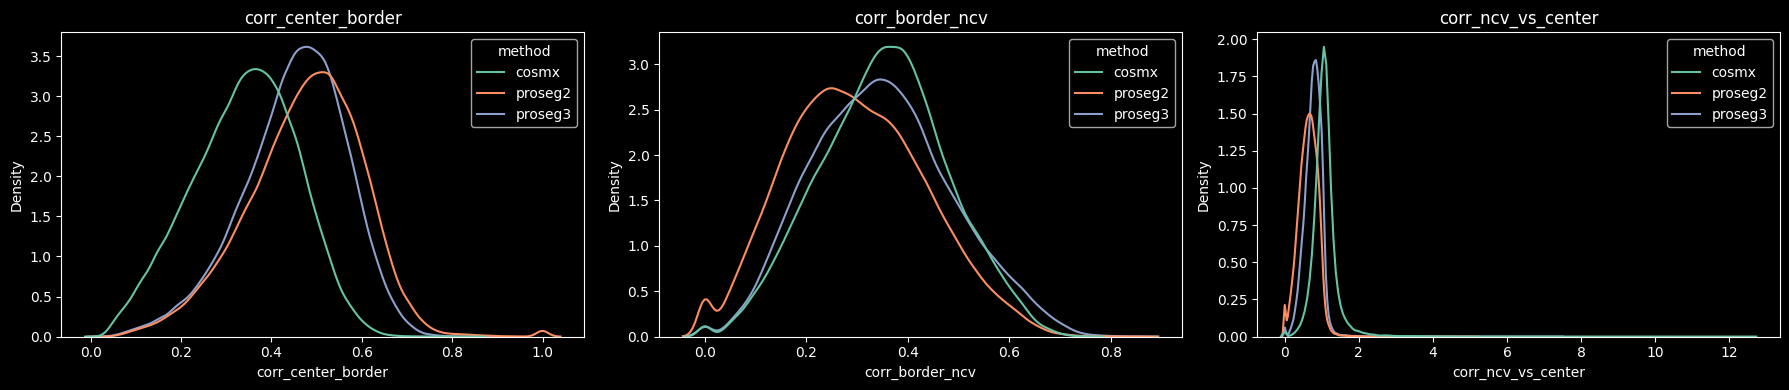

In [22]:
features = ["corr_center_border", "corr_border_ncv", "corr_ncv_vs_center"]

# Collect features into one dataframe
all_feats = []

for method, st in st_dict.items():
    feat = st.sdata["table"].obs[features]
    tmp = feat.copy()
    tmp["method"] = method
    all_feats.append(tmp)

df = pd.concat(all_feats, ignore_index=True)
df["method"] = df["method"].astype(str)

feature_cols = [c for c in df.columns if c != "method"]

# Dark style once
plt.style.use("dark_background")

n = len(feature_cols)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 4), facecolor="black")

for ax, feat in zip(axes, feature_cols, strict=False):
    ax.set_facecolor("black")
    sns.kdeplot(data=df, x=feat, hue="method", common_norm=False, palette="Set2", fill=False, ax=ax)
    ax.set_title(feat, color="white")
    ax.set_xlabel(feat, color="white")
    ax.set_ylabel("Density", color="white")
    ax.tick_params(colors="white")

fig.tight_layout()
plt.show()

## Supervised module 
We downloaded a reference single-cell RNAseq NSCLC dataset that was obtained in [this study](https://www.nature.com/articles/s41597-023-02074-6) ([download link](https://figshare.com/articles/dataset/NSCLC_Final_dataset/22114682?backTo=%2Fcollections%2FAn_integrated_single-cell_transcriptomic_dataset_for1_non-small_cell_lung_cancer%2F6222221&file=39330485)). We used `seurat-disk` to convert this into an anndata object that we can use for label transfer.

In [23]:
# Load scRNA-seq dataset
scRNAseq_data_path = Path("../../data/refquery_final.h5ad")
adata_ref = ad.read_h5ad(scRNAseq_data_path)
adata_ref

AnnData object with n_obs × n_vars = 224611 × 72131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'

In [24]:
%%time
st_cosmx.run_label_transfer(
    adata_ref, ref_cell_type="Cell_Cluster_level1", ref_ensemble_key=None, query_ensemble_key=None
)

CPU times: user 35.6 s, sys: 10 s, total: 45.6 s
Wall time: 45.7 s


/scratch/jobs/45124571/ipykernel_1780676/3427200774.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/spatialdata.py:511: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


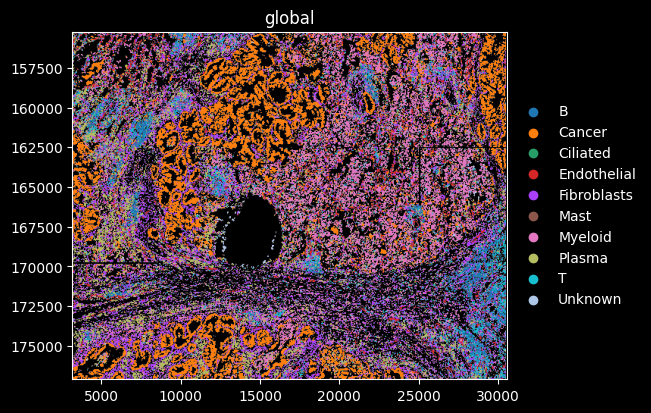

In [25]:
# TODO: not sure how much I trust these cell type annotations...
# they have some annotations here: https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/nsclc-ffpe-dataset/
# however, I could not find these in the dataset
sdata = st_cosmx.sdata

# Replace NaN with Unknown (this will not be necessary in the next version of spatialdata_plot)
s = sdata.tables["table"].obs["transferred_cell_type"]
if pd.api.types.is_categorical_dtype(s):
    s = s.cat.add_categories(["Unknown"])

sdata.tables["table"].obs["transferred_cell_type_plot"] = s.fillna("Unknown")

# Plot - Cell boundaries
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries", region_key="region", instance_key="cell")

sdata.pl.render_shapes("cell_boundaries", color="transferred_cell_type_plot").pl.show(coordinate_systems="global")

In [26]:
# TODO: continue here once the supervised module is finalized